In [1]:
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import sklearn
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
import pandas as pd

from utils import *

In [2]:
import matplotlib as mpl
import scienceplots

mpl.rcParams['text.usetex'] = True
mpl.rcParams.update(mpl.rcParamsDefault)
plt.style.use(['science', 'grid'])

In [3]:
# Load data & fix
df = pd.read_csv('data_banknote_authentication.txt', header=None)
X = df[df.columns[:-1]]
y = df[df.columns[-1]]

scaler = sklearn.preprocessing.StandardScaler()
scaler.fit(X)
X = scaler.transform(X)
y = y * 2 - 1

In [4]:
idx_pos = np.where(y == 1)[0]
idx_neg = np.where(y == -1)[0]

In [5]:
# Doublecheck fit
svm = sklearn.svm.SVC(kernel='rbf')
svm.fit(X, y=y)
svm.score(X, y=y), svm.score(X[y==-1.0], y[y==-1.0]), svm.score(X[y==1.0], y[y==1.0])

(1.0, 1.0, 1.0)

# All At Once

In [6]:
# Initialization 

SEED = 100
m = 5
p = 0.5
q = 2.0
epochs = 15
n, d = X.shape
rng = np.random.default_rng(SEED)
models = [sklearn.svm.SVC(C=1e10, kernel='rbf') for _ in range(m)]
for j in range(m):
    i_pos = idx_pos[rng.integers(len(idx_pos))]
    i_neg = idx_neg[rng.integers(len(idx_neg))]
    models[j].fit(X[[i_pos, i_neg]], y=[1, -1])
# Collect scores
y_hats = []
for j in range(m):
    y_hats.append(cap_utilities(models[j].decision_function(X)))
y_hats = torch.tensor(np.stack(y_hats).T, dtype=torch.float)
M = np.zeros_like(y_hats)

# Setup End-Of-Run Stats
y_hats_eor = []
alphas_eor = []
Ms_eor = []
models_eor = []

# Iterable
for e in range(epochs):
    y_hats_eor.append(y_hats)
    # Optimize alpha
    alpha = opt_alpha(y_hats, quiet=False, round_lr=True, q=q)
    alphas_eor.append(alpha)
    # Update memory
    M = cache_memory(alpha=alpha, mem=M, p=p)
    Ms_eor.append(M)
    # Train new models
    models = []
    for j in range(m):
        sample_weight = M.T[j]
        if not (np.any(sample_weight * y > 0) and np.any(sample_weight * y < 0)):
            models.append(models_eor[-1][j])
            continue
        models.append(sklearn.svm.SVC(C=1e10, kernel='rbf').fit(X, y=y, sample_weight=sample_weight))
    models_eor.append(models)
    # Collect new scores
    y_hats = []
    for j in range(m):
        y_hats.append(cap_utilities(models[j].decision_function(X)))
    y_hats = torch.tensor(np.stack(y_hats).T, dtype=torch.float)

Loss: -305.00/Max: 1.00: 100%|████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 115.96it/s]


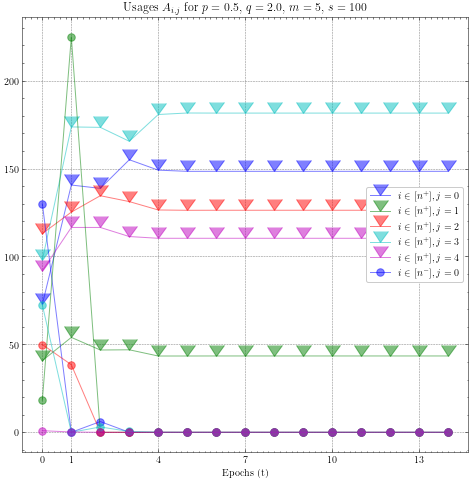

In [7]:
plt.rcParams.update({'font.size': 20})
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']

str_p = repr(str(p))[1:-1]
title = r'Usages $A_{i,j}$ for' + str_var('p', p) + str_var('q', q) + str_var('m', m) + str_var('s', SEED)[:-1]
ax.set_title(title)

lines = []
for j in range(m):
    line = ax.plot(range(epochs), [torch.sum(a.T[j][idx_pos]) for a in alphas_eor], label=r'$i \in [n^+], j=' + repr(str(j))[1:-1] + r'$', marker=7, color=colors[j],
                  alpha=0.5, markersize=15)
    lines += line
    
for j in range(m):
    line = ax.plot(range(epochs), [torch.sum(a.T[j][idx_neg]) for a in alphas_eor], label=r'$i \in [n^-], j=' + repr(str(j))[1:-1] + r'$', marker='.', color=colors[j],
                  alpha=0.5, markersize=15)
    lines += line
    
ax.set_xlabel(r'Epochs (t)')
ax.set_xticks([0] + list(range(1, epochs, 3)))
ax.legend(handles = lines[:m+1], loc=7)
plt.show()